In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, mean_squared_error, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from joblib import dump, load

In [ ]:
from google.colab import files
files.upload()

In [ ]:
# Load the dataset
df = pd.read_csv("credit_rating.csv")

df = df.drop(columns=['S.No'])
df = df.drop(columns=['S.No.'])

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CHK_ACCT                1000 non-null   object
 1   Duration                1000 non-null   int64 
 2   History                 1000 non-null   object
 3   Purpose of credit       1000 non-null   object
 4   Credit Amount           1000 non-null   int64 
 5   Balance in Savings A/C  1000 non-null   object
 6   Employment              1000 non-null   object
 7   Install_rate            1000 non-null   int64 
 8   Marital status          1000 non-null   object
 9   Co-applicant            1000 non-null   object
 10  Present Resident        1000 non-null   int64 
 11  Real Estate             1000 non-null   object
 12  Age                     1000 non-null   int64 
 13  Other installment       1000 non-null   object
 14  Residence               1000 non-null   object
 15  Num_C

In [ ]:
# Duplicate check
def duplicate_values(df):
    print("Duplicate check...")
    num_duplicates = df.duplicated(subset=None, keep='first').sum()
    if num_duplicates > 0:
        print("There are", num_duplicates, "duplicated observations in the dataset.")
        df.drop_duplicates(keep='first', inplace=True)
        print(num_duplicates, "duplicates were dropped!")
        print("No more duplicate rows!")
    else:
        print("There are no duplicated observations in the dataset.")

duplicate_values(df)

rows_with_empty_values = df[df.eq('').any(axis=1)]

# Fill empty values with np.nan in selected rows
df.loc[rows_with_empty_values.index] = df.loc[rows_with_empty_values.index].replace('', np.nan)


df.isna().sum()


Duplicate check...
There are no duplicated observations in the dataset.


CHK_ACCT                  0
Duration                  0
History                   0
Purpose of credit         0
Credit Amount             0
Balance in Savings A/C    0
Employment                0
Install_rate              0
Marital status            0
Co-applicant              0
Present Resident          0
Real Estate               0
Age                       0
Other installment         0
Residence                 0
Num_Credits               0
Job                       0
No. dependents            0
Phone                     0
Foreign                   0
Credit classification     0
dtype: int64

In [ ]:
feature_names = df.select_dtypes(include='object').columns.tolist()
feature_names

['CHK_ACCT',
 'History',
 'Purpose of credit',
 'Balance in Savings A/C',
 'Employment',
 'Marital status',
 'Co-applicant',
 'Real Estate',
 'Other installment',
 'Residence',
 'Job',
 'Phone',
 'Foreign',
 'Credit classification']

In [ ]:
df.select_dtypes(include='number')

,Duration,Credit Amount,Install_rate,Present Resident,Age,Num_Credits,No. dependents
0,6,1169,4,4,67,2,1
1,48,5951,2,2,22,1,1
2,12,2096,2,3,49,1,2
3,42,7882,2,4,45,1,2
4,24,4870,3,4,53,2,2
...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1
996,30,3857,4,4,40,1,1
997,12,804,4,4,38,1,1
998,45,1845,4,4,23,1,1


In [ ]:
df.shape

(1000, 21)

In [ ]:
df

,CHK_ACCT,Duration,History,Purpose of credit,Credit Amount,Balance in Savings A/C,Employment,Install_rate,Marital status,Co-applicant,...,Real Estate,Age,Other installment,Residence,Num_Credits,Job,No. dependents,Phone,Foreign,Credit classification
0,0DM,6,critical,radio-tv,1169,unknown,over-seven,4,single-male,none,...,real-estate,67,none,own,2,skilled,1,no,yes,good.
1,less-200DM,48,duly-till-now,radio-tv,5951,less100DM,four-years,2,female-divorced,none,...,real-estate,22,none,own,1,skilled,1,yes,yes,bad.
2,no-account,12,critical,education,2096,less100DM,seven-years,2,single-male,none,...,real-estate,49,none,own,1,unskilled-resident,2,yes,yes,good.
3,0DM,42,duly-till-now,furniture,7882,less100DM,seven-years,2,single-male,guarantor,...,building-society,45,none,free,1,skilled,2,yes,yes,good.
4,0DM,24,delay,new-car,4870,less100DM,four-years,3,single-male,none,...,none,53,none,free,2,skilled,2,yes,yes,bad.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no-account,12,duly-till-now,furniture,1736,less100DM,seven-years,3,female-divorced,none,...,real-estate,31,none,own,1,unskilled-resident,1,yes,yes,good.
996,0DM,30,duly-till-now,used-car,3857,less100DM,four-years,4,male-divorced,none,...,building-society,40,none,own,1,management,1,no,yes,good.
997,no-account,12,duly-till-now,radio-tv,804,less100DM,over-seven,4,single-male,none,...,car,38,none,own,1,skilled,1,yes,yes,good.
998,0DM,45,duly-till-now,radio-tv,1845,less100DM,four-years,4,single-male,none,...,none,23,none,free,1,skilled,1,no,yes,bad.


In [ ]:
for i in range(0,df.shape[1]):
    print(df.iloc[:,i].unique())

['0DM' 'less-200DM' 'no-account' 'over-200DM']
[ 6 48 12 42 24 36 30 15  9 10  7 60 18 45 11 27  8 54 20 14 33 21 16  4
 47 13 22 39 28  5 26 72 40]
[' critical' ' duly-till-now' ' delay' ' all-paid-duly' ' bank-paid-duly']
[' radio-tv' ' education' ' furniture' ' new-car' ' used-car' ' business'
 ' domestic-app' ' repairs' ' others' ' retraining']
[ 1169  5951  2096  7882  4870  9055  2835  6948  3059  5234  1295  4308
  1567  1199  1403  1282  2424  8072 12579  3430  2134  2647  2241  1804
  2069  1374   426   409  2415  6836  1913  4020  5866  1264  1474  4746
  6110  2100  1225   458  2333  1158  6204  6187  6143  1393  2299  1352
  7228  2073  5965  1262  3378  2225   783  6468  9566  1961  6229  1391
  1537  1953 14421  3181  5190  2171  1007  1819  2394  8133   730  1164
  5954  1977  1526  3965  4771  9436  3832  5943  1213  1568  1755  2315
  1412 12612  2249  1108   618  1409   797  3617  1318 15945  2012  2622
  2337  7057  1469  2323   932  1919  2445 11938  6458  6078  772

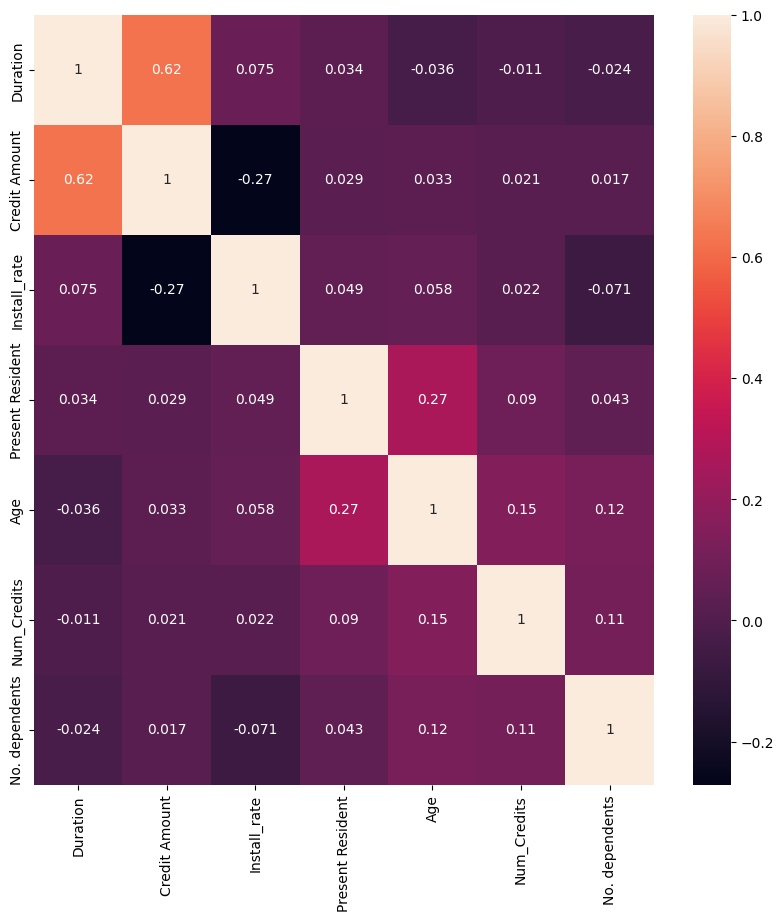

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.select_dtypes(include='number').corr(), annot = True);

In [ ]:
encoders = {}
for i in range(0,df.shape[1]):
    if df.dtypes.iloc[i]=='object':
        le = LabelEncoder()
        df[df.columns[i]] = le.fit_transform(df[df.columns[i]])
        encoders[df.columns[i]] = le


X = df.iloc[:, :-1]
y = df.iloc[:,-1]

In [ ]:
for key, value in encoders.items():
    print(key,":-",value.classes_)

In [ ]:
for key, value in encoders.items():
    print(key, ":-", dict(zip(value.classes_, value.transform(value.classes_))))

CHK_ACCT :- {'0DM': 0, 'less-200DM': 1, 'no-account': 2, 'over-200DM': 3}
History :- {' all-paid-duly': 0, ' bank-paid-duly': 1, ' critical': 2, ' delay': 3, ' duly-till-now': 4}
Purpose of credit :- {' business': 0, ' domestic-app': 1, ' education': 2, ' furniture': 3, ' new-car': 4, ' others': 5, ' radio-tv': 6, ' repairs': 7, ' retraining': 8, ' used-car': 9}
Balance in Savings A/C :- {' less1000DM': 0, ' less100DM': 1, ' less500DM': 2, ' over1000DM': 3, ' unknown': 4}
Employment :- {' four-years': 0, ' one-year': 1, ' over-seven': 2, ' seven-years': 3, ' unemployed': 4}
Marital status :- {' female-divorced': 0, ' male-divorced': 1, ' married-male': 2, ' single-male': 3}
Co-applicant :- {' co-applicant': 0, ' guarantor': 1, ' none': 2}
Real Estate :- {' building-society': 0, ' car': 1, ' none': 2, ' real-estate': 3}
Other installment :- {' bank': 0, ' none': 1, ' stores': 2}
Residence :- {' free': 0, ' own': 1, ' rent': 2}
Job :- {' management': 0, ' skilled': 1, ' unemployed-non-re

In [ ]:
X

,CHK_ACCT,Duration,History,Purpose of credit,Credit Amount,Balance in Savings A/C,Employment,Install_rate,Marital status,Co-applicant,Present Resident,Real Estate,Age,Other installment,Residence,Num_Credits,Job,No. dependents,Phone,Foreign
0,0,6,2,6,1169,4,2,4,3,2,4,3,67,1,1,2,1,1,0,1
1,1,48,4,6,5951,1,0,2,0,2,2,3,22,1,1,1,1,1,1,1
2,2,12,2,2,2096,1,3,2,3,2,3,3,49,1,1,1,3,2,1,1
3,0,42,4,3,7882,1,3,2,3,1,4,0,45,1,0,1,1,2,1,1
4,0,24,3,4,4870,1,0,3,3,2,4,2,53,1,0,2,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,12,4,3,1736,1,3,3,0,2,4,3,31,1,1,1,3,1,1,1
996,0,30,4,9,3857,1,0,4,1,2,4,0,40,1,1,1,0,1,0,1
997,2,12,4,6,804,1,2,4,3,2,4,1,38,1,1,1,1,1,1,1
998,0,45,4,6,1845,1,0,4,3,2,4,2,23,1,0,1,1,1,0,1


In [ ]:
y

0      1
1      0
2      1
3      1
4      0
      ..
995    1
996    1
997    1
998    0
999    1
Name: Credit classification, Length: 1000, dtype: int64

In [ ]:
# Create an instance of RandomOverSampler
oversample = RandomOverSampler()

# Perform oversampling on the dataset
X, y = oversample.fit_resample(X, y)

In [ ]:
X.shape

(1400, 20)

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
model = RandomForestClassifier(n_estimators=1000, random_state=42)

#dtree=DecisionTreeClassifier(criterion="entropy", max_depth=12)
# Train the model

#dtree.fit(X_train, y_train)

model.fit(X_train, y_train)

# Make predictions on the test data
#y_pred = dtree.predict(X_test)
y_pred1=model.predict(X_test)

Confusion Matrix:
[[121  10]
 [ 24 125]]
MSE: 0.12142857142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.88       131
           1       0.93      0.84      0.88       149

    accuracy                           0.88       280
   macro avg       0.88      0.88      0.88       280
weighted avg       0.88      0.88      0.88       280



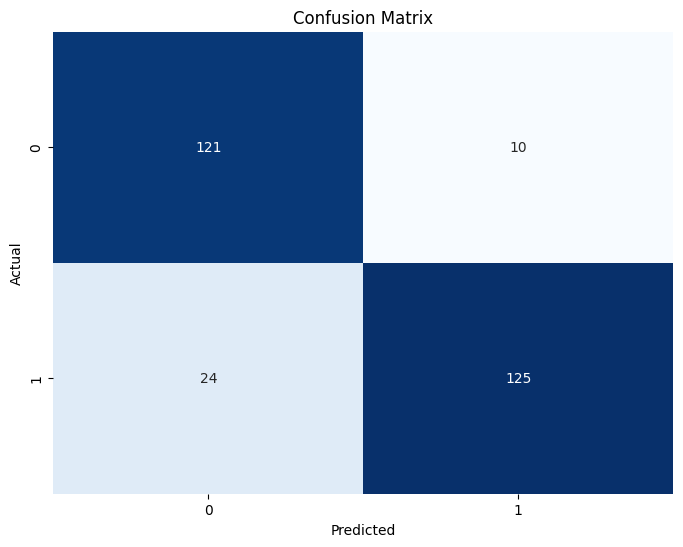

In [ ]:
# Evaluate the model's performance
conf_matrix = confusion_matrix(y_test, y_pred1)
mse= mean_squared_error(y_test, y_pred1)
clf_rep = classification_report(y_test, y_pred1)

print("Confusion Matrix:")
print(conf_matrix)
print("MSE:", mse)
print("Classification Report:\n", clf_rep)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn import metrics
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, y_pred1))

DecisionTrees's Accuracy:  0.8785714285714286


In [ ]:
import pickle
Pkl_Filename = "model1_tree.pkl"

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
from pydantic import BaseModel

class CreditApplication(BaseModel):
    CHK_ACCT: int
    Duration: int
    History: int
    Purpose_of_credit: int
    Credit_Amount: int
    Balance_in_Savings_AC: int
    Employment: int
    Install_rate: int
    Marital_status: int
    Co_applicant: int
    Present_Resident: int
    Real_Estate: int
    Age: int
    Other_installment: int
    Residence: int
    Num_Credits: int
    Job: int
    No_dependents: int
    Phone: int
    Foreign: int

    class Config:
        schema_extra = {
            "example": {
                "CHK_ACCT": 0,
                "Duration": 6,
                "History": 2,
                "Purpose_of_credit": 6,
                "Credit_Amount": 1169,
                "Balance_in_Savings_AC": 4,
                "Employment": 2,
                "Install_rate": 4,
                "Marital_status": 3,
                "Co_applicant": 2,
                "Present_Resident": 4,
                "Real_Estate": 3,
                "Age": 67,
                "Other_installment": 1,
                "Residence": 1,
                "Num_Credits": 2,
                "Job": 1,
                "No_dependents": 1,
                "Phone": 0,
                "Foreign": 1
            }
        }


In [ ]:
!pip install fastapi uvicorn

In [ ]:
from fastapi import FastAPI


app = FastAPI()

@app.on_event("startup")
def load_model():
    global model
    model = pickle.load(open("model1_tree.pkl", "rb"))

@app.get('/')
def index():
    return {'message': 'This is the homepage of the API '}


@app.post('/predict')
def get_credit_type(data: CreditApplication):
    received = data.dict()
    CHK_ACCT = received['CHK_ACCT']
    Duration = received['Duration']
    History = received['History']
    Purpose_of_credit = received['Purpose_of_credit']
    Credit_Amount = received['Credit_Amount']
    Balance_in_Savings_AC = received['Balance_in_Savings_AC']
    Employment = received['Employment']
    Install_rate = received['Install_rate']
    Marital_status = received['Marital_status']
    Co_applicant = received['Co_applicant']
    Present_Resident = received['Present_Resident']
    Real_Estate = received['Real_Estate']
    Age = received['Age']
    Other_installment = received['Other_installment']
    Residence = received['Residence']
    Num_Credits = received['Num_Credits']
    Job = received['Job']
    No_dependents = received['No_dependents']
    Phone = received['Phone']
    Foreign = received['Foreign']
    pred_name = model.predict([[CHK_ACCT,Duration,History,Purpose_of_credit,Credit_Amount,Balance_in_Savings_AC,Employment,Install_rate,Marital_status,Co_applicant,Present_Resident,Real_Estate,
                                Age,Other_installment,Residence,Num_Credits,Job,No_dependents,Phone,Foreign]]).tolist()[0]
    return {'prediction': pred_name}

In [ ]:
!pip install colabcode

In [ ]:
from colabcode import ColabCode
server = ColabCode(port=10000, code=False)

In [ ]:
!pip install pyngrok

In [ ]:
ngrok_token="2fV9bIcNGF2UXyq62UOTDwkR3XB_56Pp5JfT4Ef3sjPff1LHG"

In [ ]:
import getpass

from pyngrok import ngrok, conf

print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
conf.get_default().auth_token = getpass.getpass()

# Open a TCP ngrok tunnel to the SSH server
connection_string = ngrok.connect("22", "tcp").public_url

ssh_url, port = connection_string.strip("tcp://").split(":")
print(f" * ngrok tunnel available, access with `ssh root@{ssh_url} -p{port}`")

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth
··········
 * ngrok tunnel available, access with `ssh root@0.tcp.ngrok.io -p18584`


In [ ]:
ColabCode().set_auth_token(ngrok_token)

In [ ]:
server.run_app(app=app)

INFO:     Started server process [526]
INFO:uvicorn.error:Started server process [526]
INFO:     Waiting for application startup.
INFO:uvicorn.error:Waiting for application startup.
INFO:     Application startup complete.
INFO:uvicorn.error:Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:10000 (Press CTRL+C to quit)
INFO:uvicorn.error:Uvicorn running on http://127.0.0.1:10000 (Press CTRL+C to quit)


Public URL: NgrokTunnel: "https://f7a7-35-185-197-203.ngrok-free.app" -> "http://localhost:10000"
INFO:     2401:4900:6274:8b5c:c128:a392:3e83:694:0 - "GET / HTTP/1.1" 200 OK
INFO:     2401:4900:6274:8b5c:c128:a392:3e83:694:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     2401:4900:6274:8b5c:c128:a392:3e83:694:0 - "GET /docs HTTP/1.1" 200 OK
INFO:     2401:4900:6274:8b5c:c128:a392:3e83:694:0 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     2401:4900:6274:8b5c:c128:a392:3e83:694:0 - "GET /predict HTTP/1.1" 405 Method Not Allowed
INFO:     223.187.123.38:0 - "POST /predict HTTP/1.1" 200 OK


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


INFO:     2401:4900:6274:8b5c:3815:a0ff:fe7d:d2a9:0 - "POST /predict HTTP/1.1" 200 OK


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


INFO:     2401:4900:6274:8b5c:3815:a0ff:fe7d:d2a9:0 - "POST /predict HTTP/1.1" 200 OK


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


INFO:     2401:4900:6274:8b5c:3815:a0ff:fe7d:d2a9:0 - "POST /predict HTTP/1.1" 200 OK


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
